In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import solve_w, calc_ow, normalize_matrix


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 51)
    y = np.linspace(-width/2, width/2, 51)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000

In [3]:
def calculate_eddy(
        width=500e3,
        num_depth_layers=21,
        eta0=1,
        L=1e5,
        H=1000,
        a=1,
        b=1,
        rho0=1025,
        f0=None,
        alpha_1=0.01,
        alpha_2=0.01,
        T0=20,
        dTdz=0.005,
        dSdz=0.01,
        taper_depth=None,
        q11=1.0,
        q12=0.0,
        q22=1.0,
        center_x=None,
        center_y=None
    ):
    """
    Compute 3D geostrophic U, V, and tracer fields for an eddy whose horizontal
    center can either be a linear tilt (alpha_1, alpha_2) or a user-supplied
    1D “spiral” center at each depth.

    Parameters
    ----------
    width : float
        Total horizontal width (meters) of the square domain.
    num_depth_layers : int
        Number of vertical levels.
    eta0, L, a, b : floats
        (not used explicitly here but kept for compatibility)
    H : float
        Total depth (meters). The vertical axis goes from -H up to 0.
    rho0 : float
        Reference density (kg/m³).
    f0 : float or None
        Coriolis parameter. If None, computed at latitude -34°.
    alpha_1, alpha_2 : floats
        Tilt coefficients (only used if center_x/center_y are None).
    T0, dTdz, dSdz : floats
        Background temperature/salinity parameters (used inside sigma).
    taper_depth : float or None
        If not None, provides an exponential taper in z.
    q11, q12, q22 : floats
        Quadratic‐form shape coefficients (constant in z).
    center_x, center_y : array_like or None
        1D “center” arrays (length == num_depth_layers) giving the x‐offset
        and y‐offset of the eddy at each depth index k. If provided, they override
        the tilt (alpha_1, alpha_2). Units must match the x,y grid (meters).

    Returns
    -------
    U, V, sigma, T, S, P, x_km, y_km, z_km : arrays
        - U, V : 3D arrays of shape (nx, ny, nz) for geostrophic velocities.
        - sigma, T, S, P : 3D arrays of shape (nx, ny, nz).
        - x_km, y_km : 1D arrays (km) of horizontal coordinates (centred ±width/2).
        - z_km : 1D array (km) of depth levels, from surface (0) down to -H.
    """

    # 1. Coriolis (if needed)
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34.0))
    g = 9.81

    # 2. Create horiz/vert grids
    x = np.linspace(-width/2, width/2, 51)
    y = np.linspace(-width/2, width/2, 51)
    z = np.linspace(-H, 0.0, num_depth_layers)  # from -H to 0
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # 3. Taper (optional exponential in z)
    if taper_depth is not None:
        taper = np.exp(Z / taper_depth)
    else:
        taper = 1.0

    # 4. Determine the horizontal center at each depth
    #    If user passed center_x/center_y, build a 3D field from them.
    #    Otherwise, fallback to linear tilt:
    #        Xc_k = alpha_1 * z_k,  Yc_k = alpha_2 * z_k
    nz = num_depth_layers
    if center_x is not None and center_y is not None:
        center_x = np.asarray(center_x)
        center_y = np.asarray(center_y)
        if center_x.shape[0] != nz or center_y.shape[0] != nz:
            raise ValueError("center_x/center_y must have length == num_depth_layers")
        # build 3D fields
        Xc_field = np.zeros_like(X)
        Yc_field = np.zeros_like(Y)
        for k in range(nz):
            Xc_field[:, :, k] = center_x[k]
            Yc_field[:, :, k] = center_y[k]
    else:
        # linear tilt:
        Xc_field = alpha_1 * Z
        Yc_field = alpha_2 * Z

    # 5. Elliptical radius‐squared at each grid point
    dX = X - Xc_field
    dY = Y - Yc_field
    r2Q = q11 * dX**2 + 2.0 * q12 * dX * dY + q22 * dY**2

    # 6. Streamfunction‐like shape φ and tracer fields
    phi = np.exp(-r2Q / L**2) * taper
    T = -2.0 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    # 7. Density anomaly σ from T/S
    alpha = 2e-4
    beta = 8e-4
    sigma = rho0 * (1.0 - alpha * (T - T0) + beta * (S - 35.0))
    sigma = sigma - sigma.mean()

    # 8. Compute horizontal gradients of σ (on the x,y grid)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    # 9. Geostrophic velocities (with the same taper):
    U = (g / f0) * dsdy * taper
    V = -(g / f0) * dsdx * taper

    # 10. Flip so that surface (z=0) becomes the first index in the third axis
    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z_flipped = z[::-1]  # now z_flipped[0] = 0, z_flipped[-1] = -H

    # 11. Transpose each horizontal slice so that U[:,:,k] matches x,y ordering
    for k in range(nz):
        U[:, :, k] = U[:, :, k].T
        V[:, :, k] = V[:, :, k].T

    # 12. Return U, V, sigma, T, S, P and the grids in km
    x_km = x / 1000.0
    y_km = y / 1000.0
    z_km = z_flipped / 1000.0
    return U, V, sigma, T, S, P, x_km, y_km, z_km


In [14]:
# t from 0 → 2π (say that corresponds to 21 depth levels)
t_full = np.linspace(0, 2*np.pi, 500)  

# your original swirl (but you only need one point per depth‐level)
scale = 20.0
Xc_swirl_full = np.cos(t_full) * scale
Yc_swirl_full = np.sin(t_full) * scale
Zc_swirl_full = t_full.copy()

num_depth_layers = 21
# create the same z‐levels that calculate_eddy will use:
H = 1000.0
z_levels = np.linspace(-H, 0.0, num_depth_layers)  

# But your swirl Zc_full goes from 0 → 2π. 
# Suppose you want to map the range [−H, 0] to [0, 2π], then invert:
# In other words, when z = 0 → t = 0; when z = −H → t = 2π.
# So:    t_depth[k] =  (z_levels[k] / (-H)) * 2π
t_depth = (z_levels / (-H)) * (2*np.pi)

# interpolate your full‐spiral to exactly those 21 t‐values:
Xc_spiral = np.interp(t_depth, Zc_swirl_full, Xc_swirl_full)
Yc_spiral = np.interp(t_depth, Zc_swirl_full, Yc_swirl_full)

U, V, sigma, T, S, P, x, y, z = calculate_eddy(
    width=500e3,
    num_depth_layers=21,
    H=1000.0,
    L=1e5,
    rho0=1025,
    alpha_1=0.01,            # these tilt‐parameters are ignored now
    alpha_2=0.01,
    taper_depth=5000,
    q11=1.0, q12=0.0, q22=1.0,
    center_x=Xc_spiral,      # your 21‐element X‐center per depth
    center_y=Yc_spiral       # your 21‐element Y‐center per depth
)
X, Y = np.meshgrid(x, y)


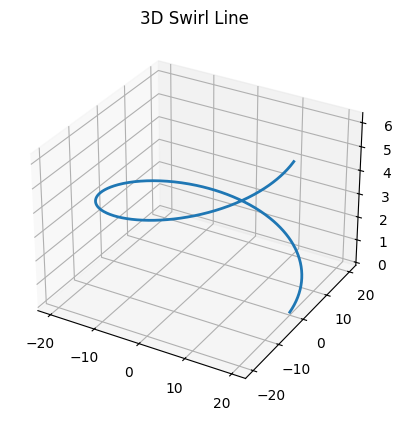

In [15]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xc_swirl_full, Yc_swirl_full, Zc_swirl_full, lw=2)
ax.set_title("3D Swirl Line")
plt.show()


In [16]:
ow = calc_ow(U, V, (x[1]-x[0])*1000, (y[1]-y[0])*1000, flag=True)
sigma_ow = normalize_matrix(ow)


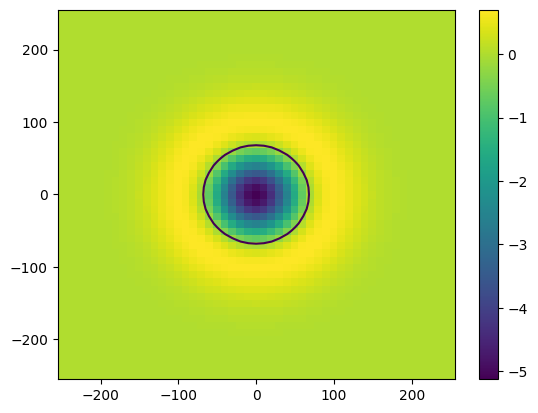

In [17]:
k = 20
plt.pcolor(X, Y, sigma_ow[:,:,k])
plt.colorbar()
plt.contour(X, Y, sigma_ow[:,:,k], levels=[-.2])


In [18]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates
dx, dy = X[0,1]-X[0,0], Y[1,0]-Y[0,0]
ow = calc_ow(U, V, dx*1000, dx*1000, flag=False)
sigma_ow = normalize_matrix(ow)

Xg, Yg, Zg = np.meshgrid(X[0, :], Y[:, 0], z, indexing='ij')

verts, faces, normals, values = marching_cubes(sigma_ow, level=-.2)
pts = verts.T
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)
real_verts = np.vstack((real_x, real_y, real_z)).T

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())
ax.invert_zaxis()
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (km)')
ax.view_init(elev=10, azim=10)


In [19]:
w = solve_w(U, V, x, y, -z*1000) 


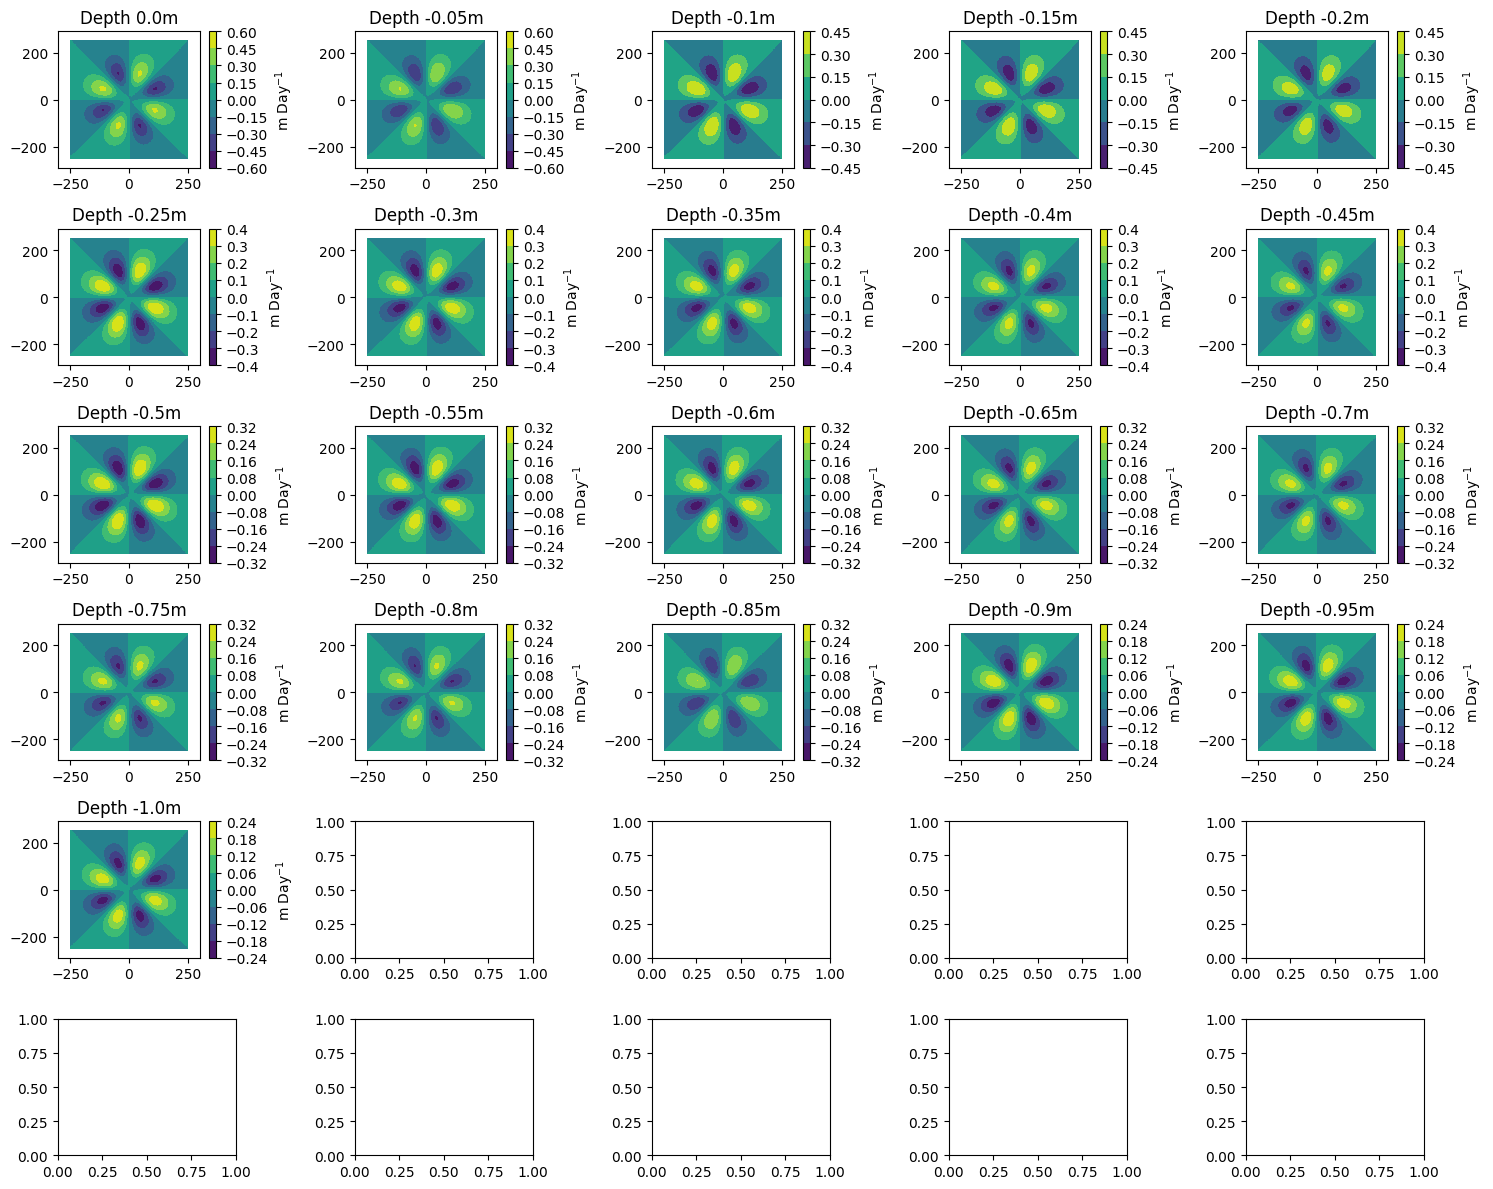

In [20]:
rows, cols = 6, 5
fig, axs = plt.subplots(rows, cols, figsize=(15, 12)) # Not taper!
for p in range(w.shape[-1]):
    ax = axs[p // cols, p % cols]
    cf = ax.contourf(X, Y, w[:, :, p] * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {z[p]}m')
    fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
plt.tight_layout()
plt.show()

In [ ]:
break

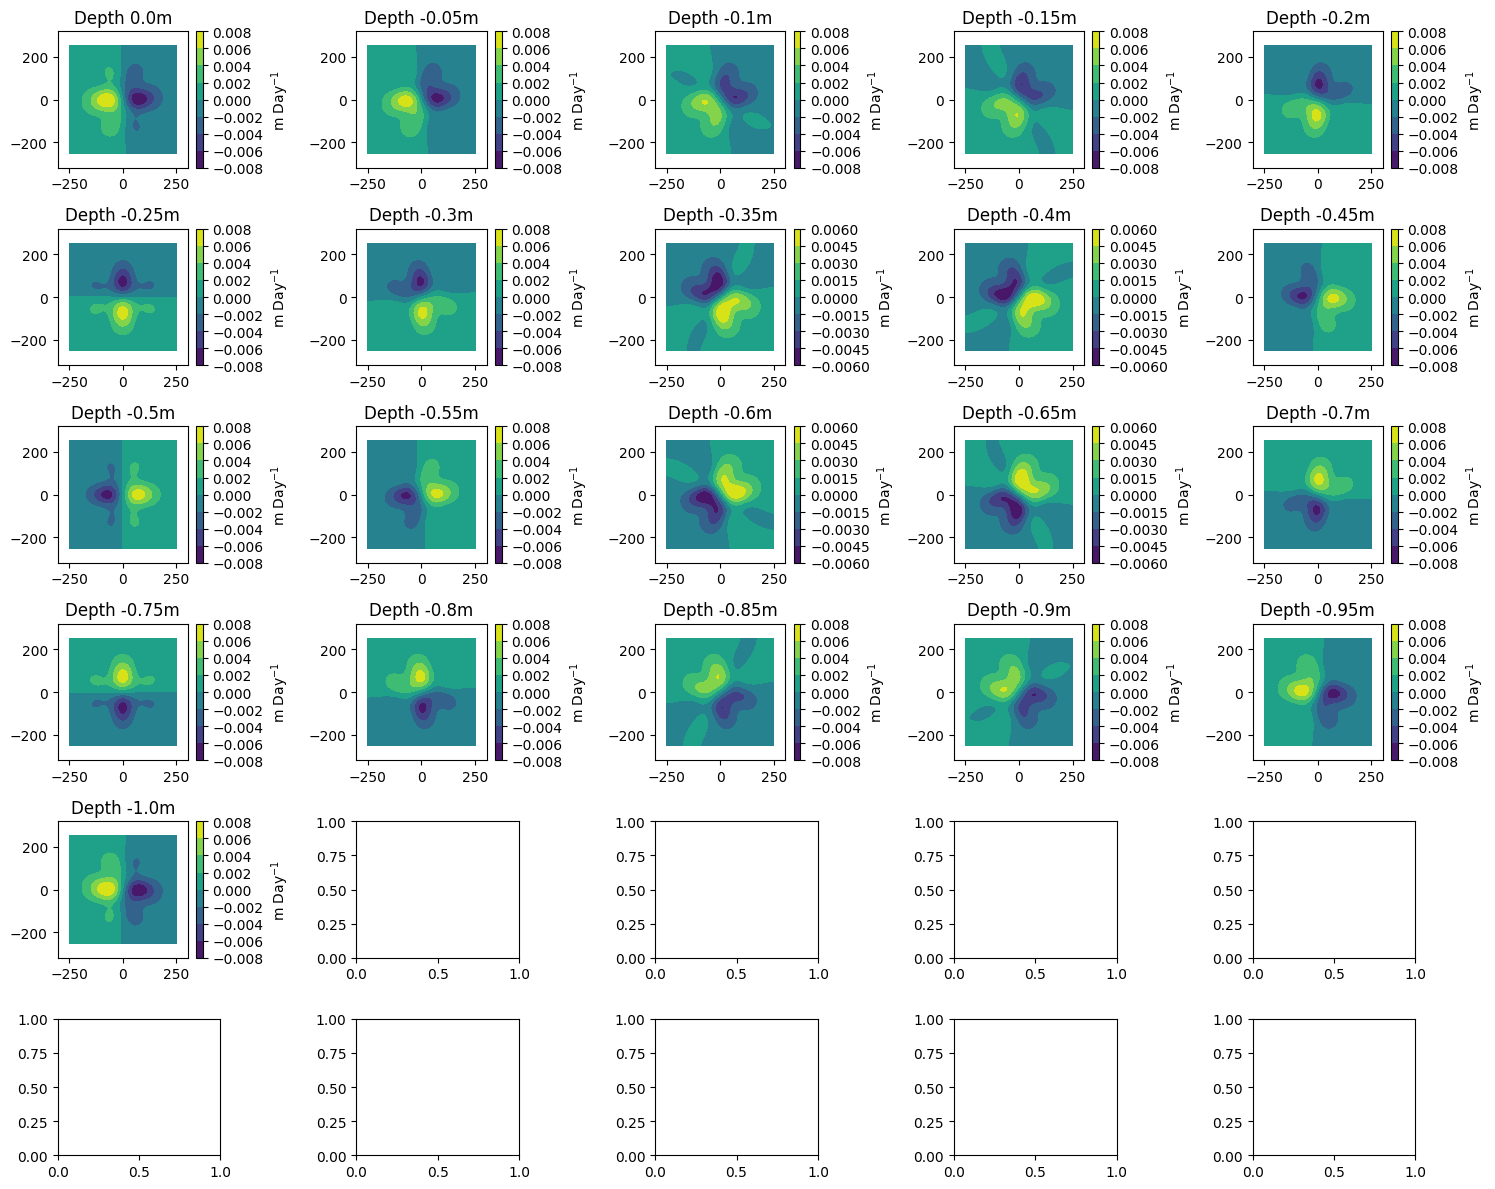

In [10]:
rows, cols = 6, 5
fig, axs = plt.subplots(rows, cols, figsize=(15, 12)) # Not taper!
for p in range(w.shape[-1]):
    ax = axs[p // cols, p % cols]
    cf = ax.contourf(X, Y, w[:, :, p] * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {z[p]}m')
    fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
plt.tight_layout()
plt.show()
